# Final project: Named Entity Recognition (NER) with Sequence Labeling Models

### Project Submission Due: Dec 16th, 2022 (11.59PM)
Please keep your code (notebook) updated in **github repo**. 

# **Introduction** 🔎

---

In this project, you will implement a model that identifies named entities in text and tags them with the appropriate label. Particularly, the task of this project is **Named Entity Recognition**. A primer on this task is provided further on. The given dataset is a modified version of the CoNLL-2003 ([Sang et al](https://arxiv.org/pdf/cs/0306050v1.pdf)) dataset. Please use the datasets that we have released to you instead of versions found online as we have made simplifications to the dataset for your benefit. Your task is to develop NLP models to identify these named entities automatically. We will treat this as a **sequence-tagging task**: for each token in the input text, assign one of the following 5 labels: **ORG** (Organization), **PER** (Person), **LOC** (Location), **MISC** (Miscellaneous), and **O** (Not Named Entity). More information about the dataset is provided later

For this project, you will implement any approach at your will (e.g. one model that is covered in the lecture):
<!-- - Model 1 : a Hidden Markov Model (HMM) -->
<!-- - Model 2 : a Maximum Entropy Markov Model (MEMM), which is an adaptation of an HMM in which a Logistic Regression classifier (also known as a MaxEnt classifier) is used to obtain the lexical generation probabilities (i.e., the observation/emission probability matrix, so "observations" == "emissions" == "lexical generations"). Feature engineering is strongly suggested for this model! -->

<!-- Implementation of the Viterbi algorithm (for finding the most likely tag sequence to assign to an input text) is required for both models above, so make sure that you understand it ASAP. -->

<!-- You will implement and train two sequence tagging models, generate your predictions for the provided test set, and submit them to **Kaggle**. Please enter all code in this colab notebook and answer all the questions in the supporting document. -->

<!-- To refresh your memory on HMMs, MEMMs, and Viterbi you can refer to **Jurafsky & Martin Ch. 8.3–8.5** and the lecture slides which can be found on EdStem. -->

## **Named Entity Recognition: A Primer**

---

Let us now take a look at the task at hand: Named Entity Recognition (NER). This section provides a brief introduction to the task and why it is important.

**What is NER?**
As we've covered in the lecture, NER refers to the information extraction technique of identifying and categorizing key information about entities within textual data. Let's look at an example: 

<br/>

![picture](https://drive.google.com/uc?id=1mxwn1_2Ef16_MJeyl9jJwwR6IohUOeHO)

<br/>

In the above example, we can see that the text has numerous named entities that can be categorized as LOC (location), ORG (organization), PER (person), etc. 
To read more on NER, we refer to any of the following sources. Medium post [1](https://umagunturi789.medium.com/everything-you-need-to-know-about-named-entity-recognition-2a136f38c08f) and [2](https://medium.com/mysuperai/what-is-named-entity-recognition-ner-and-how-can-i-use-it-2b68cf6f545d).

## **Entity Level Mean F1**

---

Let's take a look at the metrics that you will focus on in this project. The standard measures to report for NER are recall, precision, and F1 score
(also called F-measure) evaluated at the **named entity level** (not at the token level). The code for this has been provided later under the validation section under Part 2. Please use this code when evaluating your models. 

If P and T are the sets of predicted and true *named entity spans*, respectively, (e.g, the five named entity spans in the above example are "Zifa", "Renate Goetschl", "Austria", "World Cup", and "Germany") then

####<center>Precision = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{P}|}$ and Recall = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{T}|}$ .</center><br/>


####<center>F1 = $\frac{2 * \text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$. </center><br/>

For each type of named entity, e.g. *LOC*ation, *MISC*ellaneous, *ORG*anization and *PER*son, we calculate the F1 score as shown above, and take the mean of all these F1 scores to get the **Entity Level Mean F1** score for the test set. If $N$ is the total number of labels (i.e., named entity types), then

####<center>Entity Level Mean F1 = $\frac{\sum_{i = 1}^{N} \text{F1}_{{label}_i}}{N}$. </center>

More details under the validation section in Part 2.



# **Part 1: Dataset**

Load the dataset as follows:
  1. Obtain the data from eLearning.
  2. Unzip the data. Put it into your google drive, and mount it on colab as per below:

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [5]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
import json

path = os.path.join(os.getcwd(), "drive", "MyDrive", "CS6320_Final", "Data")
# print(path)
with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())

Here's a few things to note about the dataset above:
1. We have just loaded 2 json files: train and test. Please note that these files are different from the original release of the CoNNL-2003 since we have already processed and tokenized them for you. Hence, the documents are represented as a list of strings. **Note that it is not split into separate training and development/validation sets**. You will need to do this yourself as needed using the train set.
2. The train file contains the following 4 fields (each is a nested list): 
  - **'text'** - actual input tokens
  - **'NER'** - the token-level entity tag (ORG/PER/LOC/MISC/O) where **O is used to denote tokens that are not part of any named entity**
  - **'POS'** - the part of speech tag (will be handy for feature engineering of the MEMM model)
  - **'index'** - index of the token in the dataset
3. The test data only has 'text', 'POS' and 'index' fields. You will need to submit your prediction of the 'NER' tag to Kaggle. More instructions on this later!

In [7]:
# Create pandas DataFrames

final_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

limit = 128
split_limit = 512

In [8]:
def fix_long_sequences(df):
  fixed_df = pd.DataFrame(columns=['text', 'index', 'NER'])
  # print(limit)
  for i, row in df.iterrows():
    text = row['text']
    index = row['index']
    ner = row['NER']

    if len(text) > limit*2:
      print(i, text)
      print(limit)
      text1, text2, text3 = text[:limit], text[limit:limit*2], text[limit*2:]
      index1, index2, index3 = index[:limit], index[limit:limit*2], index[limit*2:]
      ner1, ner2, ner3 = ner[:limit], ner[limit:limit*2], ner[limit*2:]

      fixed_df.loc[len(fixed_df)] = [text1, index1, ner1]
      fixed_df.loc[len(fixed_df)] = [text2, index2, ner2]
      fixed_df.loc[len(fixed_df)] = [text3, index3, ner3]
      
    elif len(text) > limit:
      print(limit)
      text1, text2 = text[:limit], text[limit:]
      index1, index2 = index[:limit], index[limit:]
      ner1, ner2 = ner[:limit], ner[limit:]
    
      fixed_df.loc[len(fixed_df)] = [text1, index1, ner1]
      fixed_df.loc[len(fixed_df)] = [text2, index2, ner2]
      
    else:
      fixed_df.loc[len(fixed_df)] = [text, index, ner]
  

  return fixed_df


In [9]:
# add bogus NER column to test dataset for inference later
list_of_ner = []
for i, text in enumerate(test_df['text']):
  ner = ['O'] * len(text)
  list_of_ner.append(ner)
test_df['NER'] = list_of_ner

In [10]:
# might have to run cell a few times until output is empty!
for i in range(6):
  final_df = fix_long_sequences(final_df)
  test_df = fix_long_sequences(test_df)

128
128
128
128
128
128
8 ['Researchers', 'report', 'progress', 'in', 'muscular', 'dystrophy', '.', 'PHILADELPHIA', '1996-08-29', 'University', 'of', 'Pennsylvania', 'researchers', 'on', 'Thursday', 'said', 'a', 'new', 'gene-therapy', 'technique', 'for', 'treating', 'muscular', 'dystrophy', 'disease', 'had', 'shown', 'progress', 'in', 'laboratory', 'animals', '.', 'Word', 'of', 'the', 'findings', ',', 'to', 'be', 'published', 'in', 'the', 'Oct.', '1', 'issue', 'of', 'the', 'journal', '"', 'Human', 'Gene', 'Therapy', ',', '"', 'came', 'in', 'advance', 'of', 'the', 'annual', 'Jerry', 'Lewis', 'Labour', 'Day', 'weekend', 'telethon', 'to', 'raise', 'money', 'for', 'muscular', 'dystrophy', 'research', '.', 'Several', 'hurdles', 'must', 'be', 'overcome', 'before', 'the', 'method', 'is', 'used', 'in', 'human', 'trials', '.', 'Nevertheless', ',', '"', 'a', 'treatment', 'based', 'on', 'the', 'new', 'strategy', '....', 'may', 'have', 'the', 'potential', 'to', 'benefit', 'many', 'patients', ',', 

In [11]:
for i, text in enumerate(final_df['text']):
  # print(text)
  if len(text) > limit:
    print(i, text)

In [12]:
for i, text in enumerate(test_df['text']):
  # print(text)
  if len(text) > limit:
    print(i, text)

In [13]:
# find maximum length of sequences and compare how many sequences 
# are over lengths of 512 in training and test sets
def max_seq_length(data):
  max = 0
  max_seq = ''
  over = 0
  
  for seq in data:
    seq_len = len(seq)
    if seq_len > max:
      max = seq_len
      max_seq = seq

    if seq_len > limit:
      over += 1

  return over, max, max_seq

In [14]:
print("# of sequences in train: " + str(len(final_df['text'])))
print("# of sequences in test: " + str(len(test_df['text'])))


print(f"longest sequence in train: {max_seq_length(final_df['text'])}")
print(f"longest sequence in test: {max_seq_length(test_df['text'])}")

# of sequences in train: 1614
# of sequences in test: 412
longest sequence in train: (0, 128, ['Romania', 'state', 'budget', 'soars', 'in', 'June', '.', 'BUCHAREST', '1996-08-28', 'Romania', "'s", 'state', 'budget', 'deficit', 'jumped', 'sharply', 'in', 'June', 'to', '1,242.9', 'billion', 'lei', 'for', 'the', 'January-June', 'period', 'from', '596.5', 'billion', 'lei', 'in', 'January-May', ',', 'official', 'data', 'showed', 'on', 'Wednesday', '.', 'Six-month', 'expenditures', 'stood', 'at', '9.50', 'trillion', 'lei', ',', 'up', 'from', '7.56', 'trillion', 'lei', 'at', 'end-May', ',', 'with', 'education', 'and', 'health', 'spending', 'accounting', 'for', '31.6', 'percent', 'of', 'state', 'expenses', 'and', 'economic', 'subsidies', 'and', 'support', 'taking', 'some', '26', 'percent', '.', 'January-June', 'revenues', 'went', 'up', 'to', '8.26', 'trillion', 'lei', 'from', '6.96', 'trillion', 'lei', 'in', 'the', 'first', 'five', 'months', 'this', 'year', '.', 'Romania', "'s", 'government', 

In [15]:
def create_freq_dist(data):
  freq_table = {}
  
  for seq in data:
    seq_len = len(seq)
    if seq_len not in freq_table:
      freq_table[seq_len] = 1
    else:
      freq_table[seq_len] += 1

  return freq_table

In [16]:
dist = create_freq_dist(final_df['NER'])
dist_test = create_freq_dist(test_df['NER'])

(array([ 18.,  17.,  22.,  15.,  23.,   9.,  18.,  21.,  17., 252.]),
 array([  1. ,  13.7,  26.4,  39.1,  51.8,  64.5,  77.2,  89.9, 102.6,
        115.3, 128. ]),
 <a list of 10 Patch objects>)

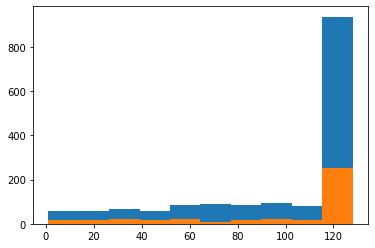

In [17]:
from matplotlib import pyplot as plt

mylist = [key for key, val in dist.items() for _ in range(val)]
mylist_test = [key for key, val in dist_test.items() for _ in range(val)]
plt.hist(mylist)
plt.hist(mylist_test)

Let's take a look at a sample sentence from the dataset!

In [18]:
print(train['text'][0])
print(train['index'][0])
print(train['POS'][0])
print(train['NER'][0])

['Romania', 'state', 'budget', 'soars', 'in', 'June', '.', 'BUCHAREST', '1996-08-28', 'Romania', "'s", 'state', 'budget', 'deficit', 'jumped', 'sharply', 'in', 'June', 'to', '1,242.9', 'billion', 'lei', 'for', 'the', 'January-June', 'period', 'from', '596.5', 'billion', 'lei', 'in', 'January-May', ',', 'official', 'data', 'showed', 'on', 'Wednesday', '.', 'Six-month', 'expenditures', 'stood', 'at', '9.50', 'trillion', 'lei', ',', 'up', 'from', '7.56', 'trillion', 'lei', 'at', 'end-May', ',', 'with', 'education', 'and', 'health', 'spending', 'accounting', 'for', '31.6', 'percent', 'of', 'state', 'expenses', 'and', 'economic', 'subsidies', 'and', 'support', 'taking', 'some', '26', 'percent', '.', 'January-June', 'revenues', 'went', 'up', 'to', '8.26', 'trillion', 'lei', 'from', '6.96', 'trillion', 'lei', 'in', 'the', 'first', 'five', 'months', 'this', 'year', '.', 'Romania', "'s", 'government', 'is', 'expected', 'to', 'revise', 'the', '1996', 'budget', 'on', 'Wednesday', 'to', 'bring', '

As you can see, the above the sentence, "Romania state budget soars in June.", has already been tokenized into an array of word tokens. The index array corresponds to the index of the token in the entire dataset (not the sentence). The POS tags and the NER tags correspond to the given indices. For example, the token: **Romania** has:
  - index: 0
  - POS: 'NNP'
  - NER: **'LOC'**

# **Part 2: Your Model**

---

In this section, you will implement a model that is covered in the lecture.
Feel free to use another notebook, or locally -- push them to your github repo.

The following is for evaluation and submission to kaggle, feel free to copy them to your implementation for evaluation.


In [19]:
unique_tags = ['LOC', 'PER', 'ORG', 'MISC', 'O']

tag2idx = {t: i for i, t in enumerate(sorted(unique_tags))}
idx2tag = {i: t for i, t in enumerate(sorted(unique_tags))}

In [20]:
print(tag2idx)

{'LOC': 0, 'MISC': 1, 'O': 2, 'ORG': 3, 'PER': 4}


In [21]:
train_df, val_df = train, val = train_test_split(final_df, test_size=0.2)

In [22]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [23]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [24]:
def address_subwords(data):
  tokenized_inputs = tokenizer(list(data["text"]), padding='max_length', max_length=split_limit, truncation=True, is_split_into_words=True)

  labels = []
  for i, tag in enumerate(data['NER']):
    word_ids = tokenized_inputs.word_ids(batch_index=i)

    prev = None
    label_ids = []

    for idx in word_ids:
        if idx is None:
            label_ids.append(-100)

        elif idx != prev and idx < len(data['text'][i]): # tokens with tags in the text
          label_ids.append(tag2idx[tag[idx]])

        else:
            label_ids.append(-100)

        prev = idx

    labels.append(label_ids)
  
  tokenized_inputs['labels'] = labels
  return tokenized_inputs

In [25]:
train_tokenized_datasets = train_dataset.map(address_subwords, batched=True)
val_tokenized_datasets = val_dataset.map(address_subwords, batched=True)
test_tokenized_datasets = test_dataset.map(address_subwords, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
config = AutoConfig.from_pretrained("bert-base-cased", id2label=idx2tag, label2id=tag2idx)

In [29]:
model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', config=config)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [30]:
# Humza
batch_size = 8

training_args = TrainingArguments(
    f"test-ner",
    learning_rate=1e-4, #5e-4, #5e-5, #1e-4,
    per_device_train_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=1e-5,
    label_names=unique_tags
)

data_collator = DataCollatorForTokenClassification(tokenizer, padding='max_length', max_length=split_limit)




In [31]:
# Humza
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_datasets,
    tokenizer=tokenizer,
)

In [32]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: __index_level_0__, NER, index, text. If __index_level_0__, NER, index, text are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1291
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 162
  Number of trainable parameters = 107723525
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, usi

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=162, training_loss=0.101570541476026, metrics={'train_runtime': 121.2875, 'train_samples_per_second': 10.644, 'train_steps_per_second': 1.336, 'total_flos': 337343262397440.0, 'train_loss': 0.101570541476026, 'epoch': 1.0})

In [51]:
model_file = './drive/MyDrive/CS6320_Final/ner-10-128-512.model'

In [34]:
trainer.save_model(model_file)

Saving model checkpoint to ./drive/MyDrive/CS6320_Final/ner-1-128-512-1e4.model
Configuration saved in ./drive/MyDrive/CS6320_Final/ner-1-128-512-1e4.model/config.json
Model weights saved in ./drive/MyDrive/CS6320_Final/ner-1-128-512-1e4.model/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/CS6320_Final/ner-1-128-512-1e4.model/tokenizer_config.json
Special tokens file saved in ./drive/MyDrive/CS6320_Final/ner-1-128-512-1e4.model/special_tokens_map.json


## **Validation Step (after your implementation)**

---

In this part of the project, we expect you to split the training data into train and validation datasets. You may use whatever split you see fit and use any external libraries to perform this split. You may want to look into the following function for splitting data: [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Once you have split the data, train your model on the training data and evaluate it on the validation data. Report **Entity Level Mean F1**, which was explained earlier. Please use the code we have provided below to compute this metric.

Please also take a look into your misclassified cases, as we will be performing error analysis in the *Evaluation* section. We expect smoothing, unknown word handling and correct emission (i.e., lexical generation) probabilities.

Consider the example below. After getting a sequence of NER labels for the sequence of tokens from your Viterbi algorithm implementation, you need to convert the sequence of tokens, associated token indices and NER labels into a format which can be used to calculate **Entity Level Mean F1**. We do this by finding the starting and ending indices of the spans representing each entity (as given in the corpus) and adding it to a list that is associated with the label with which the spans are labelled. To score your validation data on Google Colab or your local device, you can get a dictionary format as shown in the picture below from the function **format_output_labels** of both the predicted and true label sequences, and use the two dictionaries as input to the **mean_f1** function.

NOTE: We do **not** include the spans of the tokens labelled as "O" in the formatted dictionary output.

![picture](https://docs.google.com/uc?export=download&id=1M57DEHgfusVPU_hlvmiOpkS3yn9GGEgj)

In [35]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (LOC, ORG, MISC or PER) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    Eg. if [token_labels] = ["ORG", "ORG", "O", "O", "ORG"]
           [token_indices] = [15, 16, 17, 18, 19]
        then dictionary returned is 
        {'LOC': [], 'MISC': [], 'ORG': [(15, 16), (19, 19)], 'PER': []}

    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"LOC":[], "MISC":[], "ORG":[], "PER":[]}
    prev_label = token_labels[0]
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      if prev_label != label:
        end = token_indices[idx-1]
        if prev_label != "O":
            label_dict[prev_label].append((start, end))
        start = token_indices[idx]
      prev_label = label
      if idx == len(token_labels) - 1:
        if prev_label != "O":
            label_dict[prev_label].append((start, token_indices[idx]))
    return label_dict

In [36]:
# Code for mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    """ 
    Calculates the entity-level mean F1 score given the actual/true and 
    predicted span labels.
    :parameter y_pred_dict: A dictionary containing predicted labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_pred_dict: Dict<key [String] : value List[Tuple]>
    :parameter y_true_dict: A dictionary containing true labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_true_dict: Dict<key [String] : value List[Tuple]>

    Implementation modified from original by author @shonenkov at
    https://www.kaggle.com/shonenkov/competition-metrics.
    """
    F1_lst = []
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        F1_lst.append(F1)
    return np.mean(F1_lst)

In [37]:
# Usage using above example

pred_token_labels = ["ORG", "O", "PER", "PER", "O", "LOC", "O", "O", "O", "O", "MISC", "O", "O", "O", "O", "LOC"]
true_token_labels = ["ORG", "O", "PER", "PER", "O", "LOC", "O", "O", "O", "O", "MISC", "MISC", "O", "O", "O", "LOC"]
token_indices = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

y_pred_dict = format_output_labels(pred_token_labels, token_indices)
print("y_pred_dict is : " + str(y_pred_dict))
y_true_dict = format_output_labels(true_token_labels, token_indices)
print("y_true_dict is : " + str(y_true_dict))

print("Entity Level Mean F1 score is : " + str(mean_f1(y_pred_dict, y_true_dict)))

y_pred_dict is : {'LOC': [(18, 18), (28, 28)], 'MISC': [(23, 23)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
y_true_dict is : {'LOC': [(18, 18), (28, 28)], 'MISC': [(23, 24)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
Entity Level Mean F1 score is : 0.75


In [38]:
# Evaluate/validate your model here


In [52]:
tokenizer = AutoTokenizer.from_pretrained(model_file)

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [53]:
import torch
print(torch.__version__)
print('CUDA Enabled: ', torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print(f'  {device} - ' + torch.cuda.get_device_name(0))
else:
  print(f'  {device}')

1.13.0+cu116
CUDA Enabled:  True
  cuda:0 - Tesla T4


In [54]:
model = AutoModelForTokenClassification.from_pretrained(model_file, num_labels=len(unique_tags))
model.to(device)

loading configuration file ./drive/MyDrive/CS6320_Final/ner-10-128-512.model/config.json
Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/CS6320_Final/ner-10-128-512.model",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LOC",
    "1": "MISC",
    "2": "O",
    "3": "ORG",
    "4": "PER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LOC": 0,
    "MISC": 1,
    "O": 2,
    "ORG": 3,
    "PER": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [55]:
eval_dataloader = DataLoader(val_tokenized_datasets, batch_size=1)

In [63]:
# computing the F1 Score

f1 = 0
count = 0

# for eval_data in eval_dataloader:
for batch in eval_dataloader:
  
  indices = torch.cat(batch['index'])  
  labels = torch.cat(batch['labels']) 
  mask = torch.cat(batch['attention_mask']) 
  input_ids = torch.cat(batch['input_ids']) 

  labels = labels.reshape(1,labels.size()[0]).to(device)
  mask = mask.reshape(1,mask.size()[0]).to(device)
  input_ids = input_ids.reshape(1,input_ids.size()[0]).to(device)
  

  b = {'labels': labels, 'attention_mask': mask, 'input_ids': input_ids}

  outputs = model(**b)
  
  loss = outputs.loss
  logits = outputs.logits
  
  for i in range(logits.shape[0]):

    predictions = logits[i][labels[i] != -100]
    true = labels[i][labels[i] != -100]

    
    predictions = predictions.argmax(dim=1).tolist()
    true = true.tolist()

    
    predictions_labeled = [idx2tag[i] for i in predictions]
    true_labeled = [idx2tag[i] for i in true]
    
    indices = indices.tolist()

    if (len(val_dataset['text'][count]) != len(predictions_labeled) != len(val_dataset['index'][count])):
      print(count)
      print("Val Dataset Text:  ", len(val_dataset['text'][count]), val_dataset['text'][count])
      print("Model Text Data:   ", len(tokenizer.decode(torch.cat(batch['input_ids']))), tokenizer.decode(torch.cat(batch['input_ids'])))
      print("Labeled Predictio: ", len(predictions_labeled), predictions_labeled)
      print("label_id:          ", len(true_labeled), true_labeled)
      print("Original labels:   ", len(val_dataset['NER'][count]), val_dataset['NER'][count])
      print("indices: ", len(indices), indices)
      print("orig_ind:",len(val_dataset['index'][count]), val_dataset['index'][count])
      print('-----------------------------------------------------------------------------------------------')
    

    y_pred_dict = format_output_labels(predictions_labeled, indices)
    y_true_dict = format_output_labels(true_labeled, indices)
  
    f = mean_f1(y_pred_dict, y_true_dict) 
    if f != 1:
      print("entity-level f1-score: ", f)
      print("text:  ", val_dataset['text'][count])
      print("index: ", val_dataset['index'][count])
      print("NER:   ", val_dataset['NER'][count])
      print("PRED:  ", y_pred_dict)
      print("TRUE:  ", y_true_dict)
      print('---------------------------------------------')
    empty = {'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}
    if y_pred_dict != empty and y_true_dict != empty:
      f1 += mean_f1(y_pred_dict, y_true_dict) 


    count += 1
print(f1)
f1_total = f1 / len(eval_dataloader)
print(f'F1-Score: {f1_total: .4f}')

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


entity-level f1-score:  nan
text:   ['said', 'she', 'was', 'sceptical', 'about', 'whether', 'this', 'could', 'work', '.', '"', 'We', 'have', 'to', 'try', 'it', ',', 'but', 'I', 'doubt', 'if', 'this', 'is', 'possible', 'with', 'the', 'separatists', ',', '"', 'she', 'said', '.']
index:  [67398, 67399, 67400, 67401, 67402, 67403, 67404, 67405, 67406, 67407, 67408, 67409, 67410, 67411, 67412, 67413, 67414, 67415, 67416, 67417, 67418, 67419, 67420, 67421, 67422, 67423, 67424, 67425, 67426, 67427, 67428, 67429]
NER:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
PRED:   {'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}
TRUE:   {'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}
---------------------------------------------
entity-level f1-score:  0.9803921568627452
text:   ['CRICKET', '-', 'BOTHAM', 'DISMISSES', 'GATTING', 'IN', 'FIRST', 'CLASS', 'DEBUT', '.', 'LONDON', '1996-08-28', 'L

# **Part 3: Kaggle Submission**
---

Using the best-performing system from among all of your HMM and MEMM models, generate predictions for the test set, and submit them to Kaggle at https://www.kaggle.com/competitions/cs6320final. Note, you **need** to use our tokenizer as the labels on Kaggle corresponds to these. Below, we provide a function that submits given predicted tokens and associated token indices in the correct format. As a scoring metric on Kaggle, we use **Entity Level Mean F1**.

Your submission to Kaggle should be a CSV file consisting of five lines and two columns. The first line is a fixed header, and each of the remaining four lines corresponds to one of the four types of named entities. The first column is the label identifier *Id* (one of PER, LOC, ORG or MISC), and the second column *Predicted* is a list of entities (separated by single space) that you predict to be of that type. Each entity is specified by its starting and ending index (concatenated by a hypen) as given in the test corpus. 

You can use the function **create_submission** that takes the list of predicted labels and the list of associated token indices as inputs and creates the the output CSV file at a specified path.

NOTE: Ensure that there are **no** rows with *Id* = "O" in your Kaggle Submission.

![picture](https://docs.google.com/uc?export=download&id=1pQkAyOdWQz62jB-YBaj8mHuwI6iWJ1GZ)

In [44]:
import csv

def create_submission(output_filepath, token_labels, token_inds):
    """
    :parameter output_filepath: The full path (including file name) of the output file, 
                                with extension .csv
    :type output_filepath: [String]
    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = format_output_labels(token_labels, token_inds)
    with open(output_filepath, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key in label_dict:
            p_string = " ".join([str(start)+"-"+str(end) for start,end in label_dict[key]])
            writer.writerow({'Id': key, 'Predicted': p_string})

In [45]:
label_all_tokens = False

def align_word_ids(texts):
  
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True, is_split_into_words=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

In [46]:
def address_subwords_single(data):
  tokenized_inputs = tokenizer(data, padding='max_length', max_length=split_limit, truncation=True, is_split_into_words=True)

  word_ids = tokenized_inputs.word_ids()

  prev = None
  label_ids = []

  for idx in word_ids:
      if idx is None:
          label_ids.append(-100)

      elif idx != prev and idx < len(data): # tokens with tags in the text
        # label_ids.append(tag2idx[tag[idx]])
        label_ids.append(1)

      else:
          label_ids.append(-100)

      prev = idx

  return label_ids

In [47]:
out_text = []
out_pred = []
out_indices = []

for data in test_tokenized_datasets:
  
  example = data['text']
  indices = data['index']
  text = tokenizer(example, padding='max_length', max_length=split_limit, truncation=True, is_split_into_words=True, return_tensors='pt')

  mask = text['attention_mask'].to(device)
  input_ids = text['input_ids'].to(device)
  label_ids = torch.Tensor(address_subwords_single(example)).unsqueeze(0).to(device)

  b = {'attention_mask': mask, 'input_ids': input_ids}
  
  outputs = model(**b)
  
  logits = outputs.logits
  
  logits_clean = logits[label_ids != -100]

  predictions = logits_clean.argmax(dim=1).tolist()
  predictions_labeled = [idx2tag[i] for i in predictions]

  if (len(example) != len(predictions_labeled) != len(indices)):
    print(count)
    print("Test Dataset Text: ", len(example), example)
    # print("Model Text Data:   ", len(tokenizer.decode(torch.cat(batch['input_ids']))), tokenizer.decode(torch.cat(batch['input_ids'])))
    print("Labeled Predictio: ", len(predictions_labeled), predictions_labeled)
    # print("label_id:          ", len(labels[0].tolist()), labels[0].tolist())
    print("indices: ", len(indices), indices)
    # print("orig_ind:",len(data['index'][count]), data['index'][count])
    print('-----------------------------------------------------------------------------------------------')

  out_text.append(example)
  out_pred.append(predictions_labeled)
  out_indices.append(indices)

In [48]:
print(out_text)
print(out_pred)
print(out_indices)

[['Slovenia', 'and', 'Poland', 'target', 'EU', ',', 'NATO', 'membership', '.', 'LJUBLJANA', '1996-08-27', 'Slovenia', 'and', 'Poland', 'pledged', 'to', 'intensify', 'cooperation', 'on', 'Tuesday', 'and', 'reinforced', 'their', 'determination', 'to', 'join', 'the', 'European', 'Union', 'and', 'NATO', 'at', 'the', 'earliest', 'possible', 'date', '.', 'Polish', 'President', 'Aleksander', 'Kwasniewski', 'and', 'his', 'Slovenian', 'counterpart', ',', 'Milan', 'Kucan', ',', 'met', 'for', 'talks', 'at', 'the', 'start', 'of', 'a', 'two-day', 'visit', 'to', 'Slovenia', 'by', 'Kwasniewski', '.', 'It', 'was', 'their', 'fourth', 'meeting', 'this', 'year', '.', 'They', 'said', 'in', 'a', 'statement', 'they', 'agreed', 'to', 'have', 'regular', 'telephone', 'contact', 'to', 'discuss', 'progress', 'in', 'strengthening', 'ties', 'with', 'the', 'West', '.', '"', 'We', 'expect', 'our', 'cooperation', 'will', 'help', 'both', 'countries', 'towards', 'entering', 'the', 'European', 'Union', 'and', 'NATO', ',

In [49]:
final_out_pred = sum(out_pred, [])
final_out_indices = sum(out_indices, [])
print(final_out_pred)
print(final_out_indices)

['LOC', 'O', 'LOC', 'O', 'ORG', 'O', 'ORG', 'O', 'O', 'LOC', 'O', 'LOC', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'MISC', 'O', 'PER', 'PER', 'O', 'O', 'MISC', 'O', 'O', 'PER', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'ORG', 'O', 'O', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PER', 'O', 'O', 'LOC', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'MISC', 'MISC', 'ORG', 'ORG', 'ORG', 'O', 'O', 'O'

In [50]:
create_submission(path + "/predicted-1-128-512-1e4.csv", final_out_pred, final_out_indices)